In [1]:
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing

import itertools

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
def point_dis(p1,p2):
    
    dx = p2.x-p1.x
    dy = p2.y-p1.y
    
    return np.sqrt(dx*dx+dy*dy)

In [3]:
def plot_ring(lr):
    
    X = []
    Y = []
    
    for p in list(lr.coords):
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y)

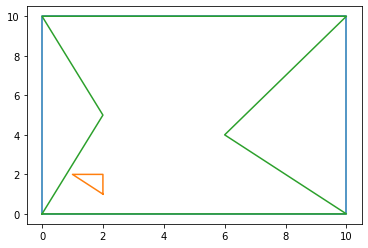

In [4]:
lr1 = LinearRing(
    [
        (0,0),
        (0, 10),
        (10,10),
        (10,0)
    ]
)

lr2 = LinearRing(
    [
        (2,1),
        (1,2),
        (2,2),
    ]
)

lr3 = LinearRing(
    [
        (0,0),
        (2,5),
        (0, 10),
        (10,10),
        (6,4),
        (10,0)
    ]
)

plot_ring(lr1)
plot_ring(lr2)
plot_ring(lr3)

LINESTRING (0 0, 0 10, 10 10, 10 0, 0 0)


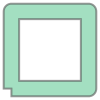

In [14]:
ls = LineString(list(lr1.coords)[0:])
print(ls)

ls.buffer(1, cap_style=2)

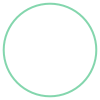

In [15]:
Point(0,0).buffer(1).exterior

In [5]:
x = LineString([(1,1),(4,5)])

In [22]:
def extend_linestring(line, dis=10):
    
    p1 = line.coords[0]
    p2 = line.coords[1]

    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    
    angle = np.arctan2(dy,dx)
    
    px = np.cos(angle)*dis + p2[0]
    py = np.sin(angle)*dis + p2[1]
    
    return LineString((line.coords[0], (px,py)))

POINT (7.75 10)


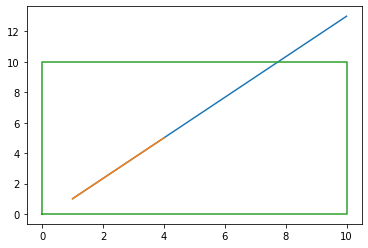

In [23]:
print(extend_linestring(x).intersection(lr1))

plot_ring(extend_linestring(x))
plot_ring(x)
pblot_ring(lr1)

In [29]:
print(Polygon(lr1).exterior)

LINEARRING (0 0, 0 10, 10 10, 10 0, 0 0)


In [4]:
def reverse(lr):
    
    return LinearRing(list(lr.coords)[::-1])
    
    
a    

26.3173315765213


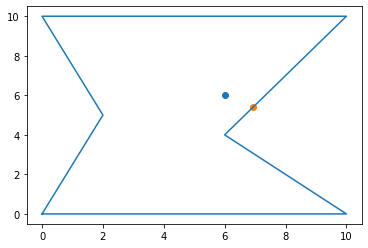

In [6]:
test_pt = Point(6,6)

dis = lr3.project(test_pt)


print(dis)

point = lr3.interpolate(dis)

plt.scatter(test_pt.x, test_pt.y)
plt.scatter(point.x, point.y)
plot_ring(lr3)

5.9422508216656595
1.2998673672393628
1.4142135623730951


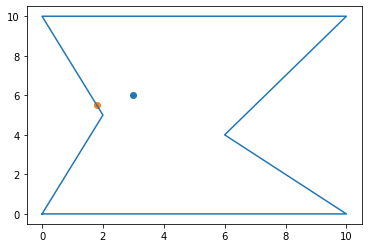

In [7]:
test_pt = Point(3,6)

dis = lr3.project(test_pt)


print(dis)

point = lr3.interpolate(dis)

plt.scatter(test_pt.x, test_pt.y)
plt.scatter(point.x, point.y)
plot_ring(lr3)


print(point.distance(test_pt))

print(test_pt.distance(Point(2,5)))

2.0
1.0


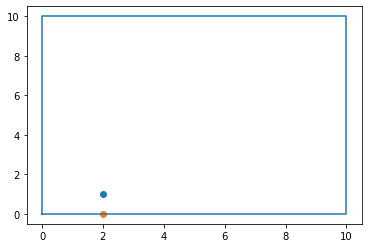

In [8]:
test_pt = Point(2,1)

rr1 = reverse(lr1)

dis = rr1.project(test_pt)


print(dis)

point = rr1.interpolate(dis)

plt.scatter(test_pt.x, test_pt.y)
plt.scatter(point.x, point.y)
plot_ring(rr1)

print(point_dis(test_pt, point))

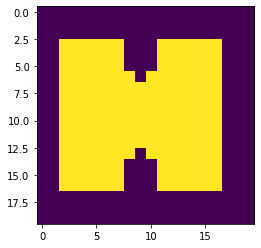

In [9]:
image = cv2.imread('area_test.png',0)
plt.imshow(image)

image = image[::1,:]


filename = "Area_test.gcode"

line_dis = 5 # mm

In [10]:
# return a list of lists of lines
def generate_border_lines(image):

    contours,heirarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)  

    contour_list = []

    for contour,heirarchy in zip(contours, heirarchy[0]):
        point_list = []
        pt0 = None
        for point in contour:
            point_list.append(tuple(point[0]))
            
        contour_list.append((point_list, heirarchy))

    return contour_list

In [11]:
# get all of the children of the parent contour
def get_children(contour_list, parent_contour):

    child_list = []

    first_child_index = parent_contour[1][2]
    child = contour_list[first_child_index]
    child_list.append(child[0])


    # loop while there are more children
    while not child[1][0] == -1:
        next_child_index = child[1][0]
        child = contour_list[next_child_index]
        child_list.append(child[0])
    
    # return the list of children
    return child_list

In [12]:
# combine contours into single level parent-children relationships
def create_contour_families(contour_list):

    family_list = []

    # find the first parent contour
    for contour in contour_list:
        
        # start with a parent contour
        if contour[1][3]==-1:

            # if there are no children, create an empty family with only the parent contour
            if contour[1][2] == -1:
                child_list = []
            # otherwise, find all of the children
            else:
                child_list = get_children(contour_list, contour)

            if len(contour[0]) > 2:
                family_list.append(Polygon(contour[0], holes=child_list))

    return family_list

In [13]:
def distance_transform(polygon, distance):
        
    t = polygon.buffer(distance)
    
    # if t is empty, return the empty list
    if not t:
        return []
        
    result = []

    if t.type == "MultiPolygon":
        for p in t:
            result.append([p])
            result[-1].extend(distance_transform(p, distance))
    else:
        result.append(t)
        result.extend(distance_transform(t, distance))
        
        
    return result

In [18]:

polygon = generate_border_lines(image)
print(polygon[0])

result = distance_transform(polygon[0],0.3)




([(2, 3), (2, 16), (7, 16), (7, 14), (9, 12), (11, 14), (11, 16), (16, 16), (16, 3), (11, 3), (11, 5), (9, 7), (7, 5), (7, 3)], array([-1, -1, -1, -1], dtype=int32))


AttributeError: 'tuple' object has no attribute 'buffer'